## 임포트 / 데이터 체크

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib inline

In [97]:
# csv 파일 불러오기
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [98]:
# 변수형 나누기
num_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("숫자형 변수: ", len(num_feats))

catg_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("객체형 변수: ", len(catg_feats))

숫자형 변수:  38
객체형 변수:  43


### 이상치 제거

In [99]:
# 이상치 제거(IQR 방법)
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step)
                              | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers


Outliers_to_drop = detect_outliers(df_train, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
                                                 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                                 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                                                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                                                 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                                                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                                                 'MiscVal', 'MoSold', 'YrSold'])

# 이상치가 발견된 행 확인
df_train.loc[Outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
165,166,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,127500
172,173,160,RL,44.0,5306,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000
910,911,90,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,154300
1292,1293,70,RM,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,107500


In [100]:
# 이상치 제거 및 결과 확인
df_train = df_train.drop(Outliers_to_drop).reset_index(drop=True)
df_train.shape

(1338, 81)

#### 변수 분리

In [101]:
# 편의를 위해 SalePrice와 관련이 큰 변수와 아닌 변수를 분리
# "Id"는 submission 때문에 따로 빼놓음

# 숫자형 변수
num_strong_corr = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars',
                   'FullBath', 'YearBuilt', 'YearRemodAdd']

num_weak_corr = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

# 범주형 변수
catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle',
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation',
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
                  'SaleCondition']

## Feature Engineering
### Log 변환
- SalePrice -> SalePrice_Log

비대칭도 : -0.032026
첨도 : 0.571897


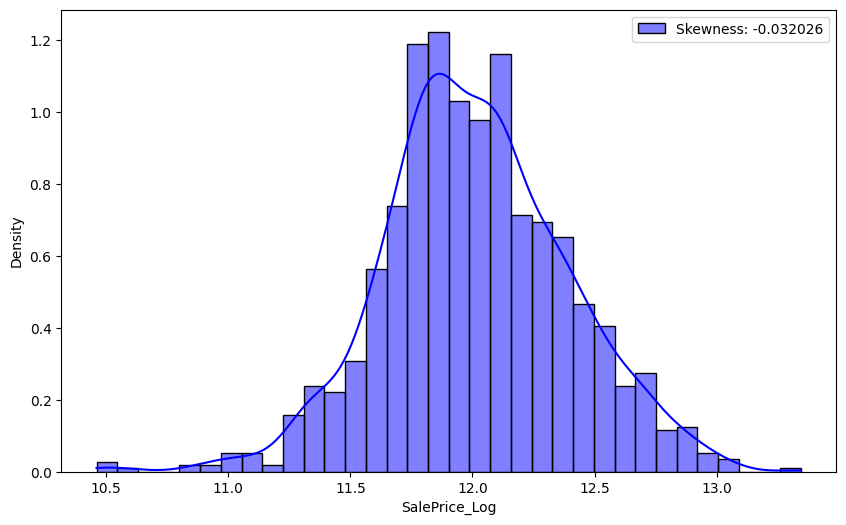

In [102]:
# 비대칭도, 첨도를 없애주기 위해 로그를 취해줌
# Log변환을 수행한 새로운 feature "SalePrice_Log"를 만들고 전 Feature인 "Saleprice"를 버림
# 로그를 취해준 그래프와 수치가 바뀐 모습을 볼 수 있음 (정규근사화)

df_train["SalePrice_Log"] = df_train["SalePrice"].map(
    lambda i: np.log(i) if i > 0 else 0)

f, ax = plt.subplots(1, 1, figsize=(10, 6))
g = sns.histplot(df_train["SalePrice_Log"], color="b", label="Skewness: {:2f}".format(
    df_train["SalePrice_Log"].skew()), kde=True, stat="density", ax=ax)
g = g.legend(loc="best")

print("비대칭도 : %f" % df_train['SalePrice_Log'].skew())
print("첨도 : %f" % df_train['SalePrice_Log'].kurt())

df_train.drop('SalePrice', axis=1, inplace=True)



### 결측 데이터 처리

In [103]:
# '없다'의 의미를 갖는 변수들
# NaN을 없다는 의미의 None으로 대체

cols_fillna = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
               'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna('None', inplace=True)
    df_test[col].fillna('None', inplace=True)

In [104]:
# 결측치의 처리 정도를 확인

total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()
           ).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [105]:
# 나머지 결측치들은 평균값으로 대체
# 바로 결측값을 채워넣기 - inplace

df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_2864\3840478734.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.fillna(df_train.mean(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2864\3840478734.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_test.fillna(df_test.mean(), inplace=True)


### 유의하지 않은 변수 삭제

In [106]:
# SalePrice와의 상관관계가 약한 모든 변수 삭제

# id 행 따로 저장
id_test = df_test['Id']

to_drop_num = num_weak_corr
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

# 삭제가 됬는지 확인
df_train.head()


,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_Log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


In [107]:
# 수치형 변환을 위해 Violinplot과 SalePrice_Log 평균을 참고하여 각 변수들의 범주들을 그룹화

# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV']


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor',
              'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN']

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']


In [108]:
# 각 범주별로 수치형 변환을 실행
for df in [df_train, df_test]:

    df['MSZ_num'] = 1
    df.loc[(df['MSZoning'].isin(msz_catg2)), 'MSZ_num'] = 2
    df.loc[(df['MSZoning'].isin(msz_catg3)), 'MSZ_num'] = 3

    df['NbHd_num'] = 1
    df.loc[(df['Neighborhood'].isin(nbhd_catg2)), 'NbHd_num'] = 2
    df.loc[(df['Neighborhood'].isin(nbhd_catg3)), 'NbHd_num'] = 3

    df['Cond2_num'] = 1
    df.loc[(df['Condition2'].isin(cond2_catg2)), 'Cond2_num'] = 2
    df.loc[(df['Condition2'].isin(cond2_catg3)), 'Cond2_num'] = 3

    df['Mas_num'] = 1
    df.loc[(df['MasVnrType'] == 'Stone'), 'Mas_num'] = 2

    df['ExtQ_num'] = 1
    df.loc[(df['ExterQual'] == 'TA'), 'ExtQ_num'] = 2
    df.loc[(df['ExterQual'] == 'Gd'), 'ExtQ_num'] = 3
    df.loc[(df['ExterQual'] == 'Ex'), 'ExtQ_num'] = 4

    df['BsQ_num'] = 1
    df.loc[(df['BsmtQual'] == 'Gd'), 'BsQ_num'] = 2
    df.loc[(df['BsmtQual'] == 'Ex'), 'BsQ_num'] = 3

    df['CA_num'] = 0
    df.loc[(df['CentralAir'] == 'Y'), 'CA_num'] = 1

    df['Elc_num'] = 1
    df.loc[(df['Electrical'] == 'SBrkr'), 'Elc_num'] = 2

    df['KiQ_num'] = 1
    df.loc[(df['KitchenQual'] == 'TA'), 'KiQ_num'] = 2
    df.loc[(df['KitchenQual'] == 'Gd'), 'KiQ_num'] = 3
    df.loc[(df['KitchenQual'] == 'Ex'), 'KiQ_num'] = 4

    df['SlTy_num'] = 2
    df.loc[(df['SaleType'].isin(SlTy_catg1)), 'SlTy_num'] = 1
    df.loc[(df['SaleType'].isin(SlTy_catg3)), 'SlTy_num'] = 3
    df.loc[(df['SaleType'].isin(SlTy_catg4)), 'SlTy_num'] = 4


In [109]:
# 기존 범주형 변수와 새로 만들어진 수치형 변수 역시 유의하지 않은 것들은 삭제
df_train.drop(['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentralAir', 'Electrical',
              'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis=1, inplace=True)
df_test.drop(['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentralAir', 'Electrical',
             'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis=1, inplace=True)

# 완벽히 삭제되어 유의하다고 판단되는 수치형 변수만 남기기
df_train.head()


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2,1,3
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,3,2,3


In [110]:
df_test.head()


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,5,1961,1961,882.0,896,1,1.0,2,1,2,1,2
1,6,1958,1958,1329.0,1329,1,1.0,3,1,2,1,3
2,5,1997,1998,928.0,1629,2,2.0,3,2,2,2,2
3,6,1998,1998,926.0,1604,2,2.0,3,2,2,1,3
4,8,1992,1992,1280.0,1280,2,2.0,3,3,3,2,3


In [111]:
feature_names = ["OverallQual",
                 "YearBuilt",
                 "YearRemodAdd",
                 "TotalBsmtSF",
                 "GrLivArea",
                 "FullBath",
                 "GarageCars",
                 "MSZ_num",
                 "NbHd_num",
                 "ExtQ_num",
                 "BsQ_num",
                 "KiQ_num"]
X_train = df_train[feature_names]
Y_train = np.exp(df_train["SalePrice_Log"])
X_train.info(),Y_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1338 non-null   int64
 1   YearBuilt     1338 non-null   int64
 2   YearRemodAdd  1338 non-null   int64
 3   TotalBsmtSF   1338 non-null   int64
 4   GrLivArea     1338 non-null   int64
 5   FullBath      1338 non-null   int64
 6   GarageCars    1338 non-null   int64
 7   MSZ_num       1338 non-null   int64
 8   NbHd_num      1338 non-null   int64
 9   ExtQ_num      1338 non-null   int64
 10  BsQ_num       1338 non-null   int64
 11  KiQ_num       1338 non-null   int64
dtypes: int64(12)
memory usage: 125.6 KB


(None,
 0    208500.0
 1    181500.0
 2    223500.0
 3    140000.0
 4    250000.0
 Name: SalePrice_Log, dtype: float64)

In [112]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200,verbose=1)
clf.fit(X_train,Y_train)
clf_score=round(clf.score(X_train,Y_train)*100,2)
clf_score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


98.33

In [113]:
# import sklearn.externals
import joblib
joblib.dump(clf,"HouseModel.pkl")

['HouseModel.pkl']